# Face Recognition vs Media Pipe

Face recognition, `face_recognition`, is a popular off the shelf face detection solution that offers a python api. Media Pipe, `mediapipe`, is a CV package with many features, including face recognition. In typical situations, both perform well, but facemasks undercut performance. This notebook will look how how the two solutions perform with masks.


## Imports and Constants

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps, ImageDraw
import os
import xml.dom.minidom
import math

import face_recognition

import cv2
import mediapipe as mp

In [2]:
# paths for the pictures from teh WWMR database
fmd_image_root =  r'D:\data\face_mask\FaceMaskDetection\images'
fmd_ano_root = r'D:\data\face_mask\FaceMaskDetection\annotations'

## Demonstration of each face detection method


### face_recognition

In [3]:
img_num = 0
test_img_name = 'maksssksksss{}.png'.format(img_num)
test_img_fp = os.path.join(fmd_image_root, test_img_name)

In [4]:
# load image into face_recognition's format with their load method
img = face_recognition.load_image_file(test_img_fp)

# detect faces with face_recognition
face_locs = face_recognition.face_locations(img)

In [5]:
# draw bounding boxes on the image
pil_image = Image.fromarray(img)
img1 = ImageDraw.Draw(pil_image)

for face in face_locs:
    t, l, b, r = face
    face1 = [(l, t), (r, b)]
    img1.rectangle(face1, outline='red')

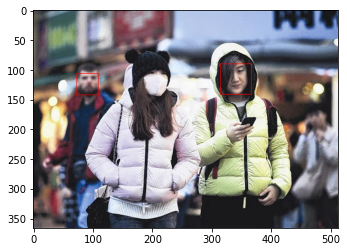

In [6]:
imgplot = plt.imshow(img1._image)

face_recognition find 2 of the 4 faces. Notice how both of the faces found are faces without masks. This is probably because the model weights were trained before covid, so maintaining performance when part of the face is obscured by a mask was likely not considered.


### Mediapipe

In [7]:
def anotation_to_box_coords(anotation):
    xmin = anotation['xmin']
    ymin = anotation['ymin']
    xmax = anotation['xmax']
    ymax = anotation['ymax']
    
    bl = (xmin, ymax)
    tr = (xmax, ymin)
    return (bl, tr)

In [8]:
def parse_annotations(anotation_fp):
    doc = xml.dom.minidom.parse(anotation_fp)
    objs = doc.getElementsByTagName('object')
    
    out_data = []
    for obj in objs:
        name, diff, xmin, ymin, xmax, ymax = None, None, None, None, None, None
        for node in obj.childNodes:

            #print(node)
            if node.nodeType == node.ELEMENT_NODE:
                if node.tagName == 'name':
                    name = node.firstChild.nodeValue
                elif node.tagName == 'difficult':
                    diff = node.firstChild.nodeValue
                elif node.tagName == 'bndbox':
                    for box_coord_node in node.childNodes:
                        if box_coord_node.nodeType == node.ELEMENT_NODE:

                            #print('\t' + str(box_coord_node))
                            if box_coord_node.nodeType == node.ELEMENT_NODE:
                                if box_coord_node.tagName == 'xmin':
                                    xmin = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'ymin':
                                    ymin = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'xmax':
                                    xmax = box_coord_node.firstChild.nodeValue
                                elif box_coord_node.tagName == 'ymax':
                                    ymax = box_coord_node.firstChild.nodeValue
        targets = [name, diff, xmin, ymin, xmax, ymax]
        if sum([x is None for x in targets]) == 0:
            box = {
                'name': name,
                'difficult': int(diff),
                'xmin': int(xmin),
                'ymin': int(ymin),
                'xmax': int(xmax),
                'ymax': int(ymax)

            }
            out_data.append(box)
    return out_data

In [9]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

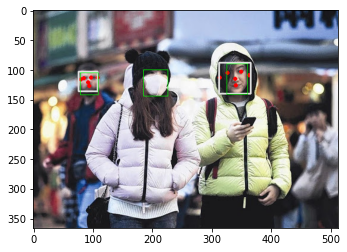

In [10]:
IMAGE_FILES = [test_img_fp]

with mp_face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5) as face_detection:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Draw face detections of each face.
        if not results.detections:
              continue
        annotated_image = image.copy()
        for detection in results.detections:
              mp_drawing.draw_detection(annotated_image, detection)
                
        # draw anotations
        ano_fp = os.path.join(fmd_ano_root, test_img_name[:-3] + 'xml')
        anotations = parse_annotations(ano_fp)
        for anotation in anotations:
            
            bl, tr = anotation_to_box_coords(anotation)
            cv2.rectangle(annotated_image, bl, tr, (0,255,0), 1)
            
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
        

The green boxes are the anotated faces. The media pipe detection is in white. The face is the top left corner is almost indetectable, and media pipe and face recognition missed it. This dataset is challenging because obscured, blurred and cropped faces are still considered. This at least gives a very real world simulation.


## Evaluation on masks and no masks dataset

Dataset has 853 images, with multiple faces per image. Masks are worn, worn incorrectly, or not worn. The classes are exclusive, meaning the mask class is correctly worn only. The dataset calls these classes 'without_mask', 'with_mask', and 'mask_weared_incorrect'

In [14]:
def face_recognition_fd(cv2_img, w, h, tol=.5):
    # go from cv2 colors to normal colors
    # cv2 is r,g,b and we want the "normal" r,b,g
    img = cv2.cvtColor(cv2_img, cv2.COLOR_RGB2BGR)
    
    # detect faces
    face_locs = face_recognition.face_locations(img)
    
    # translate output coords to cv2 format
    output = []
    for face in face_locs:
        t, l, b, r = face
        bl = (l, b)
        tr = (r, t)
        output.append((bl, tr))
    return output

In [15]:
def media_pipe_fd(cv2_img, w, h, tol=0.5):
    output = []
    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=tol) as face_detection:
        
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection
        results = face_detection.process(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
        
        if results.detections:
            for detection in results.detections:
                rbb = detection.location_data.relative_bounding_box
                rect_start_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin, rbb.ymin, w,
                  h)
                rect_end_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin + rbb.width,
                  rbb.ymin + rbb.height, w,
                  h)
                if rect_start_point is None:
                    rect_start_point = (0, 0)
                    print('error')
                
                output.append((rect_start_point, rect_end_point))
    return output

In [16]:
def norm_coords(coord, w, h):
    x, y = coord
    return (x/w, y/h)

In [17]:
def euclidian_dist(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    
    xd = x2 - x1
    yd = y2 - y1
    return math.sqrt(xd ** 2 + yd ** 2)

In [18]:
def eval_fd(df_algo, match_tolerance=0.25):
    total_detections = 0
    misses = 0
    counts = {
        'total': 0,
        'mask': 0,
        'no mask': 0,
        'incorrect mask': 0,
        'detected mask': 0,
        'detected wo mask': 0,
        'detected w incorrect mask': 0,
    }
    img_counter = 0
    #fig, ax_mat = plt.subplots(nrows=5, ncols=2, figsize=(15, 22))

    for root, subdirectories, files in os.walk(fmd_image_root):
        for file in files:  
            # create indices from counter
            #r = int(img_counter/2)
            #c = img_counter%2
            
            # get image and annotation file path
            img_fp = os.path.join(fmd_image_root, file)
            ano_fp = os.path.join(fmd_ano_root, file[:-3] + 'xml')
            
            # read the image
            image = cv2.imread(img_fp)
            h, w, d = image.shape
            
            # use the supplied face detector to detect faces
            bbs = df_algo(image, w, h, tol=.5)
            total_detections += len(bbs)

            #annotated_image = image.copy()
            #for rect_start_point, rect_end_point in bbs:
            #    cv2.rectangle(annotated_image, rect_start_point, rect_end_point, (0,255,0),2)
            #ax_mat[r][c].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
            
            # parse annotation file 
            anotations = parse_annotations(ano_fp)
            
            # match annotations to algo bounding box if under threshold
            for anotation in anotations:
                bl, tr = anotation_to_box_coords(anotation)
                
                match = None
                for bb in bbs:
                    dist = euclidian_dist(bl, bb[0])
                    # thresh = match_tolerance * math.sqrt(w * h)  # geometric mean
                    thresh = match_tolerance * ((w + h) / 2)  # arithmetric mean

                    #print(thresh)
                    if dist <= thresh:
                        match = bb
                        break

                if match is not None:
                    amt_to_inc = 1
                else:
                    amt_to_inc = 0
                    misses += 1
                    #print(file)

                counts['total'] += 1

                # mask
                if anotation['name'] == 'with_mask':
                    counts['mask'] += 1
                    counts['detected mask'] += amt_to_inc
                # no mask
                elif anotation['name'] == 'without_mask':
                    counts['no mask'] += 1
                    counts['detected wo mask'] += amt_to_inc
                # incorrect mask
                elif anotation['name'] == 'mask_weared_incorrect':
                    counts['incorrect mask'] += 1
                    counts['detected w incorrect mask'] += amt_to_inc
            
            img_counter += 1
            #if img_counter >= 15: 
            #    break
    print('detections: {}'.format(total_detections))
    print('misses: {}'.format(misses))
    return counts

In [19]:
c = eval_fd(media_pipe_fd)

error
error
error
error
error
error
error
error
error
error
error
detections: 1266
misses: 2309


In [20]:
d = eval_fd(face_recognition_fd)

detections: 465
misses: 3473


In [21]:
def print_stats(counts):
    total_detections =  sum([counts['detected mask'], 
                             counts['detected wo mask'], counts['detected w incorrect mask']])
    total_accur = total_detections / counts['total'] 
    print('total accuracy:                {:.1%}'.format(total_accur))
    
    no_mask_acccur =  counts['detected wo mask'] / counts['no mask']
    print('no mask accuracy:              {:.1%}'.format(no_mask_acccur))
    
    mask_acccur = counts['detected mask'] / counts['mask']
    print('mask accuracy:                 {:.1%}'.format(mask_acccur))
    
    incorrect_mask_acccur = counts['detected w incorrect mask'] / counts['incorrect mask']
    print('incorrect mask accuracy:       {:.1%}'.format(incorrect_mask_acccur))
    
    equal_class_accur = (no_mask_acccur + mask_acccur + incorrect_mask_acccur) / 3
    print('accuracy if equal # per class: {:.1%}'.format(equal_class_accur))


In [22]:
print('media pipe')
print_stats(c)

media pipe
total accuracy:                43.3%
no mask accuracy:              48.3%
mask accuracy:                 41.9%
incorrect mask accuracy:       50.4%
accuracy if equal # per class: 46.9%


In [23]:
print('face recognition')
print_stats(d)

face recognition
total accuracy:                14.7%
no mask accuracy:              19.8%
mask accuracy:                 13.3%
incorrect mask accuracy:       22.0%
accuracy if equal # per class: 18.4%


In [24]:
# media pipe
c

{'total': 4072,
 'mask': 3232,
 'no mask': 717,
 'incorrect mask': 123,
 'detected mask': 1355,
 'detected wo mask': 346,
 'detected w incorrect mask': 62}

In [25]:
# face recognition
d

{'total': 4072,
 'mask': 3232,
 'no mask': 717,
 'incorrect mask': 123,
 'detected mask': 430,
 'detected wo mask': 142,
 'detected w incorrect mask': 27}

We see that media pipe outperformed face recognition by a large margin. As expected, performance on no mask people is higher than on masked people. I was expecting the performance for incorrectly worn masks to be close to the masked performance, but was surprised to see that both face detection schemes performed best on this type of data. 

The significaantly better performance of media pipe compared to face recognition, which is the current face detector in the mask detecion scheme, indicates performance would increase as more faces are detected. This change will be made.